Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [79]:
NAME = "Tianyi Zhang"
COLLABORATORS = ""

---

# CIS 545 Homework 5 and 6: Amazon Review Analysis and Classification

Your main training set for this assignment is the text from 100,000 reviews from Amazon.com, their timestamps, and their star ratings. The high level goal of this homework is to use the textual and temporal data to predict the star ratings.

**Adventurers beware!** Analyzing this data in `sklearn` will likely kill your kernel. So instead we will use the package [gensim](https://radimrehurek.com/gensim/) for analysis. gensim specializes in efficient implementations of common modeling techniques for big text.

In [80]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from datetime import *

In [81]:
# read stuff
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
reviews_wc = corpora.MmCorpus('reviews_wc.mm')
reviews_sppmi_300 = np.load('reviews_sppmi_300.npy')
reviews_wv = KeyedVectors.load("word_vectors.wv", mmap='r')
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

## Step 0: Format Exploring

We will start with exploring the format of all of the data files that we imported above. 

### Step 0.1: gensim dictionary (lexicon)

Most data science over text has some form of vocabulary. Simply put, you need to decide which words your model will care about. Very rare words, misspellings, numbers, and urls are good candidates for exclusion, especially since if the model needs any form of normalization, the time complexity of such computations is at least linear in the size of the vocabulary, if not worse.

A lexicon associates each word in the vocabulary with an index. Since words are repeated, the model can save space by using the index for every repetition and only linking the index with the string form once. A `gensim` dictionary is special in that it is very fast and allows bidirectional lookups, namely, word to index and index to word.

After reviewing the [documentation](https://radimrehurek.com/gensim/corpora/dictionary.html), rewrite the right hand side of each line in the cell below with the answers to these questions.

1. What is the index of "good"? Look it up and store it in a variable named `good`. To clarify, if you find that 42 is the index of "good", change the line below so that it sets `good` equal to 42. Of course, you can do this with `good = 42` and earn full points, but it is a litte better to reuse the command with which you found the index. For example, if the `gensim` dictionary worked like a list of strings, you could do it with  
`good = reviews_dict.iloc('good')`.
2. What word belongs to index 195? Look it up and store it in a variable named `oneninefive`.
3. What happens when you evaluate `reviews_dict[i]` for some variable `i`? If this returns the word associated with that index, set `idx2word` to `True`. Otherwise, set it to `False`. For example, if `reviews_dict['good']` equals `good`, `idx2word` should be `False`, but if `reviews_dict[195]` equals `oneninefive`, `idx2word` should be `True`.

Hint: `token2id('good')` and `id2token(195)` didn't work for me either. Keep trying!

In [82]:
# dictionary_answer
good = reviews_dict.token2id['good']
oneninefive = reviews_dict[195]
idx2word = True

In [83]:
# dictionary_test_1 (5 points)
print("The index of good is", good)

The index of good is 19


In [84]:
# dictionary_test_2 (3 points)
print("Word 195 is", oneninefive)

Word 195 is brass


In [85]:
# dictionary_test_3 (2 points)
print("It is", idx2word, "that brackets can look up a word by its index.")

It is True that brackets can look up a word by its index.


### Step 0.2: Efficiently storing text

`gensim` represents everything in a **sparse** way. Namely, the representation of a review will be a variable-size list that contains counts of the words that _are present_ in the review. A **dense** representation, on the other hand, such as a matrix, would, in addition to the present words, contain zero counts for all of the words that are not in that particular review. For some examples, see [this tutorial](https://radimrehurek.com/gensim/tut1.html).

You may run the cell below as it is to see what is actually stored in a gensim [corpus](https://radimrehurek.com/gensim/corpora/mmcorpus.html). In each review, `gensim` stores a tuple of size 2 for each distinct word in the review. The first number in the tuple is the index of the word in the dictionary and the second number in the tuple is the count of the times that word appeared in that review.

Now, we would like you to add a bit of code to the cell below that "translates" the first two amazon reviews into something more readable. The reviews are already represented as bags of words, so recall that you cannot recover the order of the words in the reviews. Rather, the words are in alphabetical order. But, we would like you to spell out the repeats of each word. So, if the original review were "to be or not to be", `reviews_bow` would have something like:

`[(0, 2.0), (1, 1.0), (2, 1.0), (3, 2.0)]`

and we would like you to make the string

`"be be not or to to"`

When you are done, `readable_reviews[0]` should be the first review and `readable_reviews[1]` should be the second.

Hint: In a normal array, you would be able to access the first two reviews with the indices 0 and 1, but this is not a normal array. Therefore, we have started an iteration through the documents and put a break the loop when `i` reaches a value strictly greater than 1. 

In [86]:
# readable_answer
i = 0
readable_reviews = []
for doc in reviews_bow:
    if i > 1: break
#     print(doc)
    readable_reviews.append([])
#     print(readable_reviews)
    for item in doc:
        word = reviews_dict[item[0]]
        for j in range(int(item[1])):
            readable_reviews[i].append(word)
    readable_reviews[i]=' '.join(readable_reviews[i])
    i += 1

In [87]:
# readable_test_1 (5 points)
print(readable_reviews[0])

abl aggress also apart apart aussi away ball ball ball ball ball better cairn came certain chewer come come come design destroy destroy disappoint expos fast favorit good great hard insid just kong kong kong kong larg lb lb let littl medium medium mix money much open orka play remov roll seam short someth sorri sort squeak squeez squeez supervis terrier terrier think took tore toy tri usual wast weigh will will


In [88]:
# readable_test_2 (5 points)
print(readable_reviews[1])

bark bark bark clean day dish dish dog dump filter full funni heard know next normal opinion put regular replac return scari sinc sinc sore sound sound throat use water water water whether worth


### Step 0.3: Parsing review times

It might be useful in predicting the scores of the reviews to know when the reviews were written. In this dataset, the day of the review was recorded as the number of seconds that passed between midnight on January 1, 1970 (the beginning of time for many computer systems) and the time the review was created. This may be efficient because it is one integer, but it is not very convenient. So we are going to convert these int objects to [datetime](https://docs.python.org/3/library/datetime.html) objects:

1. Do not change `review_times` in any way. Work with other variables instead.
1. Make a new variable named `converted_times`.
2. Set that variable equal to a pandas `Series` object made from `review_times` but the entries should be of type `datetime` or `Timestamp`.

3. Make a new variable named `forty_days_before_review_times_0`. 
4. Set that variable equal to 40 days before the time of the first review, using the `timedelta` function.

Hint: You might find `datetime.fromtimestamp` to be useful.

In [89]:
# datetime_answer 
converted_times = pd.Series(pd.to_datetime(timedelta,unit='s')[0] for timedelta in reviews_times)

In [90]:
type(converted_times[0])

pandas._libs.tslibs.timestamps.Timestamp

In [91]:
forty_days_before_review_times_0 = converted_times[0]-pd.Timedelta(days=40)

In [92]:
type(forty_days_before_review_times_0)

pandas._libs.tslibs.timestamps.Timestamp

In [93]:
# datetime_test_1 (2 points)
print("converted_times is a", type(converted_times))

converted_times is a <class 'pandas.core.series.Series'>


In [94]:
# datetime_test_2 (5 points)
print("converted_times[0] is a", type(converted_times[0]))

converted_times[0] is a <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [95]:
# datetime_test_3 (3 points)
display(converted_times[0])
display(forty_days_before_review_times_0)

Timestamp('2012-05-06 00:00:00')

Timestamp('2012-03-27 00:00:00')

## Step 1: Word vectors

We saw in class that performing several optimizations on a word-context shifted positive pointwise mutual information ($SPPMI$) matrix, including decomposing with SVD, is mathematically equivalent to a neural network that learns word embeddings using skip gram with negative sampling ($SGNS$).  We are going to implement each of these here and compare against a pure bag of words ($BOW$) model as a baseline.

To begin, let's make a corpus out of our favorite toy dataset: the 5 computer science and 4 math article titles. After lower casing, tokenizing, and stop wording, the corpus looks like `titles` in the cell below. Then, we create a dictionary and a sparse document-term matrix.

In [96]:
titles = [['human', 'interface', 'computer'],
          ['survey', 'user', 'computer', 'system', 'response', 'time'],
          ['eps', 'user', 'interface', 'system'],
          ['system', 'human', 'system', 'eps'],
          ['user', 'response', 'time'],
          ['trees'],
          ['graph', 'trees'],
          ['graph', 'minors', 'trees'],
          ['graph', 'minors', 'survey']] #9 titles

titles_dict = corpora.Dictionary(titles)
titles_bow = [titles_dict.doc2bow(title) for title in titles]
display(titles_bow)

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

### Step 1.1: Sparse to dense

To get the term-document matrix that we have seen in lecture, we need to convert this matrix to its dense form. Write a function `densify` that takes as input:

1. a sparse matrix in the format of `titles_bow` above
3. an integer number of columns

and returns a NumPy array. Note that `titles_bow` is a document-term matrix, not a term-document matrix, so we transpose it in the test cell to show the matrix from lecture (with the rows and columns slightly reordered).

In [97]:
# densify_answer
def densify(sparse, columns):
    term_docum_matrix=np.zeros([len(sparse),columns])#.astype(int)
    i=0
    for doc in sparse:
        for word in doc:
            term_docum_matrix[i][word[0]]=word[1]
#     print(type(term_docum_matrix))
        i+=1
    return term_docum_matrix #已经是ndarray了


In [98]:
# densify_test_1 (5 points)
td = densify(titles_bow, len(titles_dict)).transpose()
print(td)

[[1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


In [99]:
# densify_test_2 (5 points)
print(td.shape)

(12, 9)


### Step 1.2: Counting words

Write a function `count_words` that takes as input:

1. a dictionary in the format of `titles_dict` above
2. a bag of words corpus in the format of `titles_bow` above

and returns a list called `counts` that has the total occurrences of each word in the corpus, in the order of the original word indices. Note that a gensim dictionary only counts a word once per document, so we can't directly use `titles_dict`.

In [100]:
# count_words_answer
def count_words(gsdict, gsbow):
    counts=[0]*len(gsdict)
    for i in gsbow:
        for j in i:
            counts[j[0]]=counts[j[0]]+j[1]
    return counts


In [101]:
# count_words_test_1 (5 points)
titles_counts = count_words(titles_dict, titles_bow)
display(len(titles_counts))

12

In [102]:
# count_words_test_2 (5 points)
display(titles_counts)

[2, 2, 2, 2, 2, 4, 2, 3, 2, 3, 3, 2]

The cell below makes the counts for the 100,000 Amazon reviews.

In [103]:
reviews_counts = count_words(reviews_dict, reviews_bow)

### Step 1.3: The word-context matrix

Now, write a function `word_context` that takes as input:

1. a dictionary in the format of `titles_dict` above
2. a corpus in the format of `titles` above
3. a window size (integer)

and creates a **sparse** word-context matrix. Recall that the word-context matrix is a square matrix and the number of rows/columns is the number of words in the vocabulary/dictionary. A nonzero term in this matrix represents the number of times word $i$ appears within (and including) the window size distance of word $j$. The word-context matrix for this toy corpus is in the lecture slides, so you may use that to check your work.

_Note: the only time a word should be in the context of itself is when it occurs with a second instance of that word, for example in the fourth "document" of the titles corpus._

In [104]:
from collections import Counter
def word_context(gsdict, gscorpus, window):
    word_context_matrix=[[]]*len(gsdict)
#     print(word_context_matrix)
    for doc in gscorpus:
        for i in range(len(doc)):
            for j in range(window): 
                if i+j+1<=len(doc)-1:
                    word_context_matrix[gsdict.token2id[doc[i]]]=word_context_matrix[gsdict.token2id[doc[i]]]+[gsdict.token2id[doc[i+j+1]]]
                if i-(j+1)>=0:
                    word_context_matrix[gsdict.token2id[doc[i]]]=word_context_matrix[gsdict.token2id[doc[i]]]+[gsdict.token2id[doc[i-(j+1)]]]
#     print(word_context_matrix)
    return [Counter(doc).most_common(len(gsdict)) for doc in word_context_matrix]


In [105]:
# word_context_test_1 (5 points)
titles_wc = word_context(titles_dict, titles, 2)
display(titles_wc)

[[(2, 1), (1, 1), (5, 1), (7, 1), (3, 1), (4, 1)],
 [(5, 2), (2, 1), (0, 1), (8, 1)],
 [(0, 1), (1, 1), (5, 1), (7, 1), (8, 1)],
 [(6, 2), (5, 1), (0, 1), (7, 1)],
 [(7, 1), (0, 1), (11, 1), (10, 1)],
 [(7, 2), (1, 2), (5, 2), (3, 1), (0, 1), (6, 1), (2, 1), (8, 1)],
 [(3, 2), (5, 1), (7, 1)],
 [(5, 2), (0, 1), (4, 1), (2, 1), (8, 1), (3, 1), (6, 1)],
 [(7, 1), (2, 1), (5, 1), (1, 1)],
 [(10, 2), (11, 1)],
 [(9, 2), (11, 2), (4, 1)],
 [(10, 2), (9, 1), (4, 1)]]

In [106]:
# word_context_test_2 (5 points)
display(densify(titles_wc, len(titles_dict))) 

array([[0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [1., 2., 1., 1., 0., 2., 1., 2., 1., 0., 0., 0.],
       [0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 2., 1., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.]])

### Step 1.4: Enhancing the word-context matrix

In lecture, we saw a number of possible enhancements for word-context matrices. Write a function `sppmi` that takes as input:

1. a sparse word-context matrix in the format of `titles_wc` above
3. a counts dictionary
4. a float `logk`

and returns a new sparse word-context matrix with the values in the matrix replaced by shifted positive pointwise mutual informations ($SPPMI$). The formula is:

$$SPPMI = \max(\log (\frac{\#(w,c) |D|}{\#(w)\#(c)}) - \log(k), 0)$$

where $\#(w,c)$ is the count of word $w$ in context $c$ (the original count from the last section), $\#(w)$ is the count of word $w$, $\#(c)$ is the count of word $c$ (both come from `titles_counts`), $|D|$ is the length of the corpus, and $k$ is a free hyperparameter.

In [107]:
# sppmi_answer
def sppmi(gswc, counts, logk):
    D=sum(counts)
    sppmi_matrix=[]
    i=0
    for doc in gswc:
        matrix=[]
        for word in doc:
            sppmi=max(np.log((word[1]*D)/(counts[i]*counts[word[0]]))-logk,0)
            matrix.append((word[0],sppmi))
        sppmi_matrix.extend([matrix])
        i=i+1
    return np.array(sppmi_matrix)


In [108]:
# sppmi_test_1 (5 points)
titles_sppmi = sppmi(titles_wc, titles_counts, 0)

In [109]:
# sppmi_test_1 (5 points)
titles_dense_sppmi = densify(titles_sppmi, len(titles_dict))
display(titles_dense_sppmi.round(1))

array([[0. , 2. , 2. , 2. , 2. , 1.3, 0. , 1.6, 0. , 0. , 0. , 0. ],
       [2. , 0. , 2. , 0. , 0. , 2. , 0. , 0. , 2. , 0. , 0. , 0. ],
       [2. , 2. , 0. , 0. , 0. , 1.3, 0. , 1.6, 2. , 0. , 0. , 0. ],
       [2. , 0. , 0. , 0. , 0. , 1.3, 2.7, 1.6, 0. , 0. , 0. , 0. ],
       [2. , 0. , 0. , 0. , 0. , 0. , 0. , 1.6, 0. , 0. , 1.6, 2. ],
       [1.3, 2. , 1.3, 1.3, 0. , 1.3, 1.3, 1.6, 1.3, 0. , 0. , 0. ],
       [0. , 0. , 0. , 2.7, 0. , 1.3, 0. , 1.6, 0. , 0. , 0. , 0. ],
       [1.6, 0. , 1.6, 1.6, 1.6, 1.6, 1.6, 0. , 1.6, 0. , 0. , 0. ],
       [0. , 2. , 2. , 0. , 0. , 1.3, 0. , 1.6, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.9, 1.6],
       [0. , 0. , 0. , 0. , 1.6, 0. , 0. , 0. , 0. , 1.9, 0. , 2.3],
       [0. , 0. , 0. , 0. , 2. , 0. , 0. , 0. , 0. , 1.6, 2.3, 0. ]])

The cell below converts the counts to $SPPMI$s in the word-context matrix for the 100,000 Amazon reviews.

In [110]:
reviews_sppmi = sppmi(reviews_wc, reviews_counts, np.log(5))

### Step 1.5: Sparse SVD/PCA/LSA/LSI

One of the greatest benefits of gensim is that there is no need to densify the matrix before decomposing. Indeed, they post some impressive numbers about their SVD speed [here](https://radimrehurek.com/gensim/models/lsimodel.html). But for now, we will test it just on our toy dataset. In the cell below, write a function called `reconstruction` that takes as input:

1. a sparse matrix
2. a gensim dictionary
2. a cutoff for PCA

The function should compute the norm of the difference of the reconstructed matrix and the original, and return that dividing by the norm of the original.

Hint: The right singular vectors ($V$ or `model[sparse]`) already contain the singular values ($S$ or `model.projection.s`) so don't include them again!

In [111]:
# reconstruction_answer
####这里有要求是12*9还是9*12吗？？？

def reconstruction(sparse, gsdict, cutoff):
    lsi_model = LsiModel(sparse, id2word=gsdict,num_topics=cutoff)#LsiModel(num_terms=12, num_topics=2, decay=1.0, chunksize=20000)
    vector = lsi_model[sparse]#每个文档用num_topics个维度表示（降维）e.g.[(0, 0.6594664059797396), (1, 0.1421154440372992)]
    #每个topic对应的向量 e.g.[ 0.24047023  0.22135078  0.1976454   0.26503747  0.20591786  0.64448115  0.26503747  0.40359886  0.30082816  0.01274618  0.03613585  0.03175633]
    #print(lsi_model.get_topics())
    vector=densify(vector, cutoff).transpose()
    U = lsi_model.projection.u
    svd_matrix = np.dot(U,vector)
#     print(svd_matrix)
    orig_matrix = densify(sparse, len(gsdict)).transpose()
#     print(orig_matrix)
    norm = np.linalg.norm(svd_matrix-orig_matrix)/np.linalg.norm(orig_matrix)
#     print(np.linalg.norm(svd_matrix-orig_matrix),np.linalg.norm(orig_matrix))
    return norm
cutoff = 2


In [112]:
# reconstruction_test_1 (5 points)

error = reconstruction(titles_bow, titles_dict, cutoff)
print("The reconstruction error with", cutoff, "components on the the toy dataset is", error)

The reconstruction error with 2 components on the the toy dataset is 0.6569296073921538


In [113]:
# reconstruction_test_2 (5 points)
cutoff = 9
error = reconstruction(titles_bow, titles_dict, cutoff)
print("The reconstruction error with", cutoff, "components on the the toy dataset is", error)

The reconstruction error with 9 components on the the toy dataset is 1.2233732791388357e-15


### Step 1.6: Assembling the dense representation

The last step in this process is to combine our two datasets, namely the document-term matrix and the word-context matrix. The appeal is that rather than reducing dimensionality by choosing a very small vocabulary, we can select relevant features from a vector space that contains all of the words. However, this requires a heavy assumption: a document representation is the sum of the representations of its words. This does not allow any non-compositionality of language (which we know there is some) and it makes each word equally important (which arguably is false as well).

In the cell below, write a function `vec2doc` that takes as input:

1. a bag of words corpus in the format of `titles_bow` above
2. a list of word vectors in proper order (by dictionary index) like `reviews_wv` above

and returns a dense matrix. This matrix contains one vector per document which was computed by summing all of the vectors corresponding to the words in the document (including repeats).

In [114]:
# vec2doc_answer
def vec2doc(gsbow, vectors):
    doc_vectors=[]
    for doc in gsbow:
        vector=[0]*len(vectors[0])
        for term in doc:
            vector = vector+vectors[term[0]]*term[1]
        doc_vectors.extend([vector])
    return np.array(doc_vectors)
            

In [115]:
# vec2doc_test_1 (5 points)
vecs_sppmi = vec2doc(reviews_bow, reviews_sppmi_300)

In [116]:
# vec2doc_test_2 (5 points)
display(vecs_sppmi.shape)

(100000, 300)

## Step 2: Feature selection and hyperparameter tuning

By this point, you have already written most of the code to import and use the word embeddings made by `word2vec`. Once both are loaded and the hyperparameters are set, you are ready to compare them against the bag of words baseline on the classification task.

### Step 2.1: Assembling the other dense representation

The only small structural difference between the word vectors that you computed and the `word2vec` embeddings is that your word vectors use a vocabulary/dictionary for indexing, whereas `word2vec` vectors are accessed using a Python dictionary. So, to access the vector for the word "good" you would need to use the integer `good` in `vecs_sppmi[good]` and the string 'good' in `reviews_wv['good']`.

Since string lookups can be inefficient and so you may maximally reuse your code, write a function `use_dict` that takes as input:

1. a dictionary in the format of `titles_dict` above
2. `KeyedVector word2vec` embeddings, as in `reviews_wv`

and returns a list of vectors indexed using the input dictionary.

In the unlikely case that you are missing a vector, just set the value at that index to the integer `0`.

In [117]:
# use_dict_answer
def use_dict(gsdict, vectors):
#     i=0
    dict2vec=[]
    for k,v in gsdict.items():
        if v in vectors:
            dict2vec.extend([vectors[v]])
        else:
            dict2vec.extend([[0]*300])
#             i+=1
#     print(i)
    return np.array(dict2vec)

In [118]:
# use_dict_test (5 points)
reviews_sgns_300 = use_dict(reviews_dict, reviews_wv)
vecs_sgns = vec2doc(reviews_bow, reviews_sgns_300)

print(reviews_sgns_300.shape,reviews_sgns_300[:10])
print(vecs_sgns.shape,vecs_sgns[:10])

### Step 2.2: PCA on pure BOW

While the $SPPMI$ and $SGNS$ models are already dimensionality reduced, it would be a good idea to also run PCA on the $BOW$ baseline. Train a gensim `LsiModel` on `reviews_bow` using `reviews_dict` as the dictionary and 1000 components.

In [119]:
# pca_bow_answer
max_cutoff = 1000
model = LsiModel(reviews_bow, id2word=reviews_dict,num_topics=max_cutoff)

Once it is finished, use the code below to plot the explained variance versus number of components. You just need to pass in a list of singular values (no `diag` necessary).

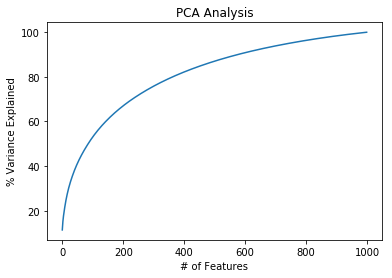

In [120]:
def plot_variance_vs_features(singular_values, cutoff):
    evr = np.array([singular_values[i]**2 / sum(singular_values**2) for i in range(cutoff)])
    var = np.cumsum(evr*100)
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(var)
    
plot_variance_vs_features(model.projection.s, max_cutoff)

The good news is this curve is very steep in the beginning, which shows that a lot of information is conveyed in the first components. However, there is no plateau that we can use to choose a cutoff!

**So, instead, we will break off a validaton set and use classifier performance to tune this hyperparameter.**

In [121]:
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 195)
    rfor = RandomForestClassifier(n_estimators=51, random_state=195)
    rfor.fit(X_train, y_train)
    return rfor.score(X_test, y_test)

### Step 2.3: Choosing the number of components via the downstream task

In some ways, this method of choosing the number of components is even better than the plateau method, because we are optimizing directly on the machine learning task rather than something intrinsic to the dataset. In the cell below, call `evaluate model` on models between 10 and 30 PCA components. For each model, you will need to train an `LsiModel`, compute the $V$ matrix (right singular vectors), call `densify` on that, and pass the dense matrix to evaluate model. Store all of your accuracies in a list named results.

In [122]:
# baseline_tuning_answer
results=[]

for cutoff in range(10,30):
    lsi_model = LsiModel(reviews_bow, id2word=reviews_dict,num_topics=cutoff)
    vector = lsi_model[reviews_bow]
    verc_dens = densify(vector,cutoff)
    results.append(evaluate_model(verc_dens, reviews_times, y))


In [123]:
# baseline_tuning_test (5 points)
display(results)

[0.6667,
 0.66485,
 0.6682,
 0.6704,
 0.6771,
 0.681,
 0.68505,
 0.69355,
 0.69405,
 0.6895,
 0.6885,
 0.6881,
 0.6908,
 0.6901,
 0.6914,
 0.69215,
 0.69005,
 0.6903,
 0.6918,
 0.69065]

In [124]:
# final_sppmi_test (5 points)
final_sppmi = evaluate_model(vecs_sppmi, reviews_times, y)
print(final_sppmi)

0.77575


In [125]:
# final_sgns_test (5 points)
final_sgns = evaluate_model(vecs_sgns, reviews_times, y)
print(final_sgns)

0.7404


## Step 3: In-class Kaggle competition

To conclude this homework and this class, we are opening up to a more flexible system. We would like for you to use everything you have learned in CIS 545 to make the best star rating predictor possible. For grading purposes, we are going to check (manually) whether you thought about and worked on each of the subsections that follow. These sections will be pass/fail and the questions under each of the headlines are meant to help you brainstorm, not impose requirements.

**Beyond that, a small amount of extra credit will be awarded to the students with the best performing models. We should be able to maintain an (anonymous) leaderboard on Piazza. Scores on this leaderboard will correspond to performance on our test set, which has not been released to you. Therefore, our TAs will run your models on our test data and report the results to ensure fairness.**

### Step 3.1: Scaling

What is the range of values for each feature? Are they comparable? Do some dominate others? Try minmax, standard, log, exponential, binary, or thresholding. How are predicted 1 star rating and predicted 5 star ratings different? How are actual 1 star ratings and actual 5 star ratings different? 

In [126]:
from gensim.test.utils import get_tmpfile
from gensim.test.utils import datapath

In [127]:
####I attempt to find the statistic info (e.g. min, max, std...) of word_context: reviews_wv(9189*300)
#term_context: reviews_wv(9189*300)统计量
word_list = reviews_wv.index2entity
vect_list=[]
for word in word_list:
    vect_list.append(reviews_wv.get_vector(word))
# vect_arr=np.array(vect_list)
pd.DataFrame(vect_list).describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,...,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000,9189.000000
mean,0.058262,-0.033631,0.041070,-0.044175,-0.078115,0.024482,-0.018873,0.052698,0.002627,-0.012680,...,0.016049,-0.006967,0.022748,0.001205,-0.011652,0.073403,0.000506,-0.041447,-0.021036,0.007522
std,0.261580,0.289418,0.361857,0.294736,0.314829,0.236379,0.242887,0.244256,0.295381,0.254308,...,0.248347,0.284525,0.258713,0.354126,0.298317,0.280874,0.269664,0.263705,0.272901,0.296020
min,-2.467928,-2.641507,-1.972841,-2.710880,-1.983194,-1.932557,-1.785748,-1.874861,-1.751582,-2.320272,...,-2.047910,-2.091035,-1.921271,-2.765815,-2.512758,-1.861384,-2.838996,-1.633574,-1.878602,-2.327044
25%,-0.037738,-0.116469,-0.107568,-0.120270,-0.183136,-0.043928,-0.093538,-0.018378,-0.081538,-0.077276,...,-0.048362,-0.106176,-0.023963,-0.125796,-0.106548,-0.009215,-0.054327,-0.132708,-0.097891,-0.092965
50%,0.027478,-0.025608,-0.017046,-0.035300,-0.083329,0.017771,-0.030124,0.043586,0.006416,-0.000908,...,0.020181,-0.033371,0.052265,-0.028867,-0.027264,0.067478,0.021160,-0.056809,-0.018326,-0.014201
75%,0.111019,0.051211,0.101697,0.045960,0.008859,0.088420,0.040319,0.122681,0.088574,0.067510,...,0.085454,0.053639,0.117139,0.082440,0.062203,0.161967,0.091488,0.020120,0.063325,0.073476
max,2.213986,2.818943,3.163550,1.929852,2.227429,1.762195,1.898351,1.724058,2.990526,2.185570,...,1.955422,1.866928,2.068863,2.438714,2.160171,1.982823,2.480895,1.699782,1.802526,2.119577


In [128]:
####I attempt to find the statistic info (e.g. min, max, std...) of word_context: reviews_sppmi_300(18716*300)
#term_context: reviews_sppmi_300(18716*300)统计量
pd.DataFrame(reviews_sppmi_300).describe()  

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,...,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000,18716.000000
mean,2.992991,0.835029,0.020938,-0.045607,-0.158176,-0.189476,0.089974,-0.085138,-0.017074,-0.147132,...,0.000223,0.001891,0.000484,0.001708,0.001080,-0.003700,0.003773,-0.000544,-0.003807,0.001366
std,2.789018,1.729957,1.814173,1.505106,1.396262,1.361097,1.250892,1.209908,1.142137,1.120996,...,0.505064,0.504745,0.504603,0.504381,0.503673,0.503472,0.503116,0.502805,0.502443,0.502146
min,0.000000,-12.808408,-25.611084,-13.766142,-13.711670,-12.686065,-11.507061,-14.484530,-14.770571,-11.750525,...,-4.588469,-3.964112,-4.941276,-4.567020,-4.551216,-3.742399,-3.697272,-3.530463,-4.430338,-4.013879
25%,1.038041,0.668862,-0.252891,-0.546125,-0.672933,-0.701968,-0.305780,-0.483202,-0.394578,-0.585762,...,-0.254369,-0.243786,-0.249681,-0.246111,-0.243043,-0.257851,-0.246776,-0.248554,-0.244253,-0.249476
50%,1.787420,1.087117,0.193498,-0.079001,-0.246918,-0.276399,0.073256,-0.081768,-0.043141,-0.213003,...,0.000000,0.001705,0.000000,0.001726,0.001691,-0.007124,0.007658,0.000337,-0.003688,0.001196
75%,3.976144,1.644855,0.597712,0.385872,0.216323,0.167912,0.477971,0.301824,0.317352,0.187886,...,0.251423,0.248116,0.250899,0.251544,0.247643,0.247823,0.252820,0.248444,0.236872,0.251244
max,18.474248,3.472698,9.753481,11.561458,14.779714,14.277768,10.578323,12.530534,13.256178,10.040801,...,3.526127,4.655981,4.527338,4.925699,4.182201,3.434678,4.777249,4.018170,5.559527,4.209589


In [129]:
####I attempt to find the statistic info (e.g. min, max, std...) of doc_vecs: reviews_sgn(100000*300)
#doc_word: reviews_sgn(100000*300)统计量
pd.DataFrame(vecs_sgns).describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,10.803637,-1.917994,13.075489,-6.313184,0.213263,-0.930227,2.789115,-1.146147,-2.703712,-1.511301,...,-1.481764,4.123847,-8.752472,10.385097,2.527592,-3.163026,-5.571206,5.228125,-4.070264,2.085950
std,14.213573,10.624586,17.652499,11.048162,9.697049,6.572720,7.270471,7.774971,9.552806,9.665582,...,7.070668,9.933806,12.315424,14.855487,10.742198,9.554643,10.107585,9.609169,8.151074,9.186289
min,-22.403530,-659.835732,-25.008198,-400.704108,-190.610656,-135.553975,-130.685799,-135.427381,-203.014930,-462.116746,...,-383.926633,-62.727630,-515.739061,-98.664268,-156.266846,-145.879827,-309.518855,-263.828649,-214.339255,-151.980062
25%,3.187942,-4.936592,3.603138,-8.392971,-3.126317,-3.644074,-0.497755,-4.250301,-5.599930,-4.136183,...,-3.750654,-0.687959,-11.218338,2.788586,-2.527888,-6.140879,-8.109155,0.600743,-6.533600,-1.929063
50%,6.846116,-0.628860,7.893387,-3.996766,0.507453,-1.041205,1.910868,-1.393095,-1.713841,-0.730099,...,-0.865886,1.922965,-5.578458,6.625385,0.998418,-2.671618,-3.735360,3.312887,-2.753825,1.199670
75%,13.601962,2.954241,16.225452,-1.080557,4.192851,1.501098,5.005590,1.443865,1.473298,2.277680,...,1.656278,6.018357,-2.302417,13.182242,5.462177,0.135121,-0.729927,7.460024,-0.150910,5.033796
max,727.985827,128.427628,699.400545,65.317332,305.223385,212.755227,384.109523,456.174837,466.475724,240.384752,...,206.074268,360.657242,30.687339,509.422153,632.853809,913.224785,622.493698,233.238431,304.391424,220.812795


In [130]:
####I attempt to find the statistic info (e.g. min, max, std...) of doc_vecs: vecs_sppmi(100000*300)
#doc_word: vecs_sppmi(100000*300)统计量
pd.DataFrame(vecs_sppmi).describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,383.581609,-237.491820,24.228618,-5.389999,-59.684102,-47.607748,30.321604,-22.748717,-6.831839,-52.965723,...,2.243597,1.452724,-1.669828,-1.495837,0.470368,-3.099827,2.379512,-1.583207,1.224345,1.378461
std,458.666731,259.723426,118.446931,66.017235,81.607254,62.292212,60.997587,56.516851,50.467999,78.050432,...,8.947965,8.237613,9.342866,9.829500,8.609761,9.644686,8.261565,9.409446,8.578503,8.662484
min,0.000000,-12395.359909,-10056.815165,-2384.067223,-2210.643516,-3357.451288,-1072.785466,-3471.674173,-1101.070460,-3114.877347,...,-124.333236,-234.200473,-360.908073,-204.798170,-127.385520,-228.086252,-123.921771,-548.853690,-178.403833,-134.941267
25%,139.340700,-285.422729,3.222603,-20.113528,-81.364201,-63.971595,2.633204,-36.017659,-19.180741,-67.313938,...,-2.172923,-2.387382,-5.280361,-5.272793,-3.561990,-6.550924,-1.666746,-5.060666,-2.955505,-2.798117
50%,244.372911,-158.451244,23.191218,-0.363367,-42.643215,-34.609426,19.710370,-14.195645,-4.612873,-31.879558,...,1.581341,1.169167,-0.998015,-0.876696,0.300137,-2.049475,1.838972,-0.901924,0.749510,0.836860
75%,454.172218,-92.998579,50.846036,18.593560,-20.118392,-15.532371,45.620539,0.200599,7.381107,-12.890651,...,5.811290,4.878139,2.809393,3.169197,4.359484,1.819618,5.725626,2.775040,4.798000,4.833902
max,23301.461658,9.714351,2158.861216,1414.267199,4934.680890,1713.948906,4502.891442,961.572688,3634.215471,556.731541,...,232.460385,210.498529,359.677637,305.777489,193.464977,214.777268,153.946080,165.300491,233.423266,308.694432


In [131]:
####I attempt to scale doc_vecs: vecs_sgns, vecs_sppmi by minmax
from sklearn.preprocessing import MinMaxScaler
minmaxscaler=MinMaxScaler()
vecs_sgns_minmax=minmaxscaler.fit_transform(vecs_sgns)
vecs_sppmi_minmax=minmaxscaler.fit_transform(vecs_sppmi)

In [132]:
####I attempt to scale doc_vecs: vecs_sgns, vecs_sppmi by standard
from sklearn.preprocessing import StandardScaler
standscaler=StandardScaler()
vecs_sgns_std=standscaler.fit_transform(vecs_sgns)
vecs_sppmi_std=standscaler.fit_transform(vecs_sppmi)

In [133]:
####I attempt to scale doc_vecs: vecs_sgns, vecs_sppmi by log
#log估计涉及到x为负的问题，所以用了minmax
from sklearn.preprocessing import FunctionTransformer
log_trans = FunctionTransformer(np.log1p, validate=True)
vecs_sgns_log=log_trans.fit_transform(vecs_sgns_minmax)
vecs_sppmi_log=log_trans.fit_transform(vecs_sppmi_minmax)

In [134]:
####I attempt to scale doc_vecs: vecs_sgns, vecs_sppmi by exponential
exp_trans = FunctionTransformer(np.expm1, validate=True)
vecs_sgns_exp=exp_trans.fit_transform(vecs_sgns)
vecs_sppmi_exp=exp_trans.fit_transform(vecs_sppmi)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:201: RuntimeWarning: overflow encountered in expm1
  **(kw_args if kw_args else {}))
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:201: RuntimeWarning: overflow encountered in expm1
  **(kw_args if kw_args else {}))


In [135]:
####I attempt to scale doc_vecs: vecs_sgns, vecs_sppmi by binary
from sklearn.preprocessing import Binarizer
binarizer = Binarizer()
vecs_sgns_bin=binarizer.fit_transform(vecs_sgns)
vecs_sppmi_bin=binarizer.fit_transform(vecs_sppmi)

In [136]:
####I attempt to scale doc_vecs: vecs_sgns, vecs_sppmi by threshold
binarizer = Binarizer(threshold=pd.DataFrame(vecs_sgns).mean().tolist())
vecs_sgns_bimean=binarizer.fit_transform(vecs_sgns)
binarizer = Binarizer(threshold=pd.DataFrame(vecs_sppmi).mean().tolist())
vecs_sppmi_bimean=binarizer.fit_transform(vecs_sppmi)

### Step 3.2: Clustering

What is the distribution of ratings? How else might this dataset be artificially balanced? What patterns can you find? Are there detectable clusters? Are some ratings easier to classify than others?

In [137]:
#### I attempt to use cluster to distinguish data (e.g. one cluster may have more data on 1 star)
#### here I use vecs_sgns data
#### I find scaled data with threshold=mean and 5 or 6 clusters distinct data well

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#processed data:vecs_sgn cluster
# x_doc_vects=np.hstack((vecs_sgns,reviews_times))
clust_num=6
x_train, x_test, y_train, y_test = train_test_split(vecs_sgns_bimean,y)
kmeans = KMeans(n_clusters=clust_num).fit(x_train)
kmeans.cluster_centers_

array([[0.77056452, 0.20819892, 0.58575269, ..., 0.33642473, 0.30134409,
        0.35443548],
       [0.84645206, 0.28757355, 0.88944271, ..., 0.78601592, 0.32384908,
        0.69865005],
       [0.24172929, 0.54799721, 0.24490587, ..., 0.36515069, 0.54249632,
        0.50213063],
       [0.40978125, 0.81607914, 0.45492546, ..., 0.63745297, 0.61320886,
        0.47749756],
       [0.01838008, 0.69558592, 0.00614256, ..., 0.0624256 , 0.79753345,
        0.26355888],
       [0.01371571, 0.91072319, 0.01404821, ..., 0.19808811, 0.87348296,
        0.33059019]])

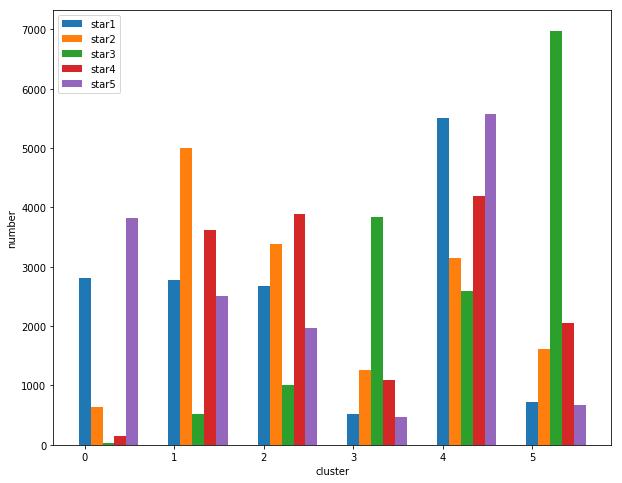

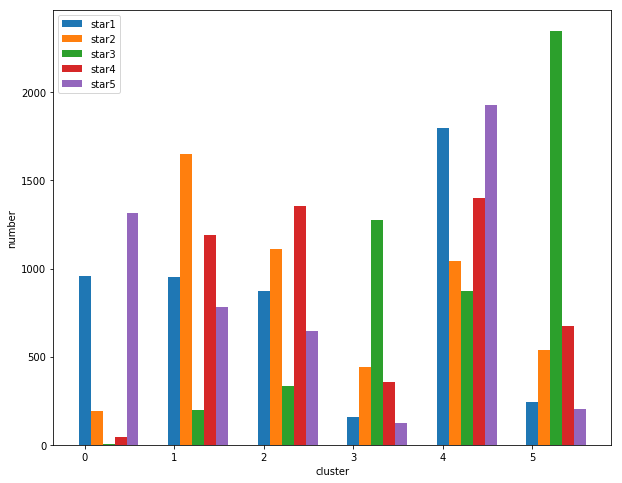

In [138]:
#### I plot the number of data in each kmeans cluster with each actual star
#### cluster 0 and 2 are good at identify 3-star, cluster 3 is good at identify 1-star and 5-star

import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import math
train_group=pd.DataFrame({'kmeans':kmeans.labels_,'actual':y_train})
sgns_train_result=train_group.groupby(['actual','kmeans']).size()

test_group=pd.DataFrame({'kmeans':kmeans.predict(x_test),'actual':y_test})
sgns_test_result=test_group.groupby(['actual','kmeans']).size()
width=10/(clust_num*5*2.5)

plt.figure(figsize=(10,8))
plt.xticks(range(clust_num))
for i in range(1,6):
    plt.bar(sgns_train_result[i].index+(i-1)*width,sgns_train_result[i],width=width,label='star'+str(i))
plt.ylabel('number')
plt.xlabel('cluster')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,8))
plt.xticks(range(clust_num))
for i in range(1,6):
    plt.bar(sgns_test_result[i].index+(i-1)*width,sgns_test_result[i],width=width,label='star'+str(i))
plt.ylabel('number')
plt.xlabel('cluster')
plt.legend(loc='best')
plt.show()


In [139]:
#### I attempt to use cluster to distinguish data (e.g. one cluster may have more data on 1 star)
#### here I use vecs_sppmi data
#### I find scaled data with threshold=mean and 5 or 6 clusters distinct data well

#processed data:vecs_sppmi cluster
# x_doc_vects=np.hstack((vecs_sppmi,reviews_times))
clust_num=5
x_train, x_test, y_train, y_test = train_test_split(vecs_sppmi_bimean,y)
kmeans = KMeans(n_clusters=clust_num).fit(x_train)
kmeans.cluster_centers_

array([[0.86836709, 0.08177044, 0.70527632, ..., 0.43445861, 0.53033258,
        0.54763691],
       [0.00128562, 0.99962503, 0.23944718, ..., 0.65309621, 0.39066852,
        0.36742018],
       [0.16164886, 0.80306464, 0.81881947, ..., 0.54343369, 0.36959102,
        0.44340132],
       [0.34927265, 0.62480196, 0.24211436, ..., 0.55739594, 0.55710788,
        0.46291229],
       [0.09753068, 0.9365032 , 0.43190739, ..., 0.55870224, 0.48313211,
        0.46037661]])

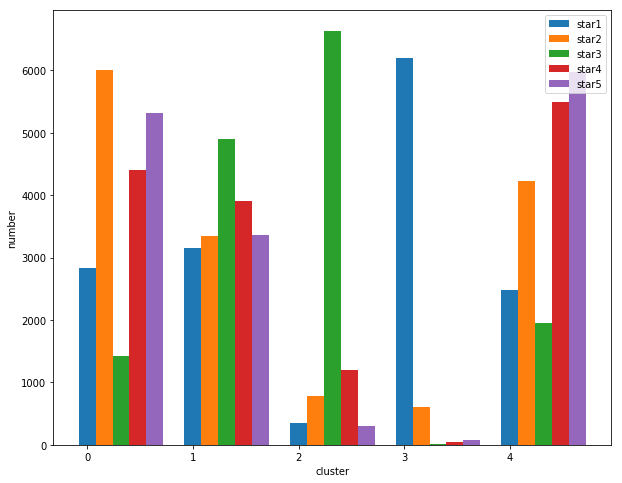

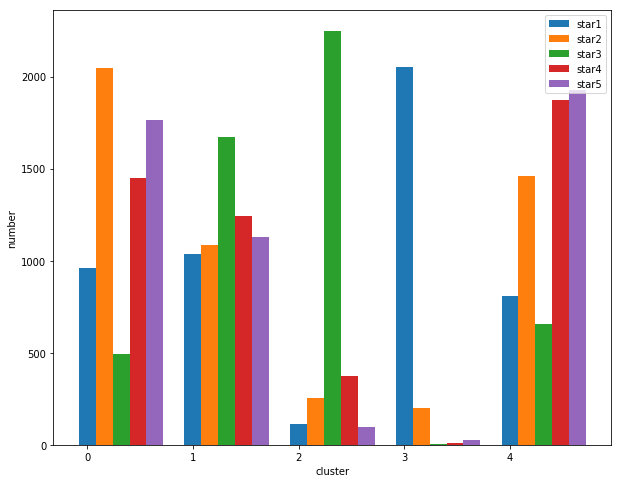

In [140]:
#### I plot the number of data in each kmeans cluster with each actual star
#### cluster 1 is good at identify 3-star, cluster 2 is good at identify 1-star

train_group=pd.DataFrame({'kmeans':kmeans.labels_,'actual':y_train})
sppmi_train_result=train_group.groupby(['actual','kmeans']).size()

test_group=pd.DataFrame({'kmeans':kmeans.predict(x_test),'actual':y_test})
sppmi_test_result=test_group.groupby(['actual','kmeans']).size()
width=10/(clust_num*5*2.5)

plt.figure(figsize=(10,8))
plt.xticks(range(clust_num))
for i in range(1,6):
    plt.bar(sppmi_train_result[i].index+(i-1)*width,sppmi_train_result[i],width=width,label='star'+str(i))
plt.ylabel('number')
plt.xlabel('cluster')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,8))
plt.xticks(range(clust_num))
for i in range(1,6):
    plt.bar(sppmi_test_result[i].index+(i-1)*width,sppmi_test_result[i],width=width,label='star'+str(i))
plt.ylabel('number')
plt.xlabel('cluster')
plt.legend(loc='best')
plt.show()

### Step 3.3: Regression

In the baseline models, star ratings were treated as categorical variables. So the models had no sense that a rating of 4 stars is in between ratings of 3 stars and 5 stars. What are the advantages and disadvantages of that approach? If you reformulate the problem as regression, how do you measure success? Is that way of measuring fair to the classifiers?

In [141]:
#### I attampt to use linear regression to predict score
#### I find scaled data with threshold=mean has the best performance here
#### I find vecs_sppmi has a better performance but even a little below 0.5 for the score of test data

from sklearn.linear_model import LinearRegression

def linear_evaluate(x_doc_vecs,y):
    x_train, x_test, y_train, y_test = train_test_split(x_doc_vecs,y)
    lr = LinearRegression()
    src=lr.fit(x_train, y_train) 
    pred=lr.predict(x_test)
    scores=lr.score(x_test,y_test)
    return scores

In [142]:
scores_minmax=linear_evaluate(vecs_sgns_minmax,y)
# scores_std=linear_evaluate(vecs_sgns_std,y)
scores_log=linear_evaluate(vecs_sgns_log,y)
# scores_exp=linear_evaluate(vecs_sgns_exp,y)
# scores_bin=linear_evaluate(vecs_sgns_bin,y)
scores_bimean=linear_evaluate(vecs_sgns_bimean,y)

In [143]:
print(scores_minmax)
# print(scores_std)
print(scores_log)
# print(scores_exp)
# print(scores_bin)
print(scores_bimean)

0.3551544817766955
0.3574561210494449
0.4174911540396297


In [144]:
scores_minmax=linear_evaluate(vecs_sppmi_minmax,y)
# scores_std=linear_evaluate(vecs_sppmi_std,y)
scores_log=linear_evaluate(vecs_sppmi_log,y)
# scores_exp=linear_evaluate(vecs_sppmi_exp,y)
# scores_bin=linear_evaluate(vecs_sppmi_bin,y)
scores_bimean=linear_evaluate(vecs_sppmi_bimean,y)

In [145]:
print(scores_minmax)
# print(scores_std)
print(scores_log)
# print(scores_exp)
# print(scores_bin)
print(scores_bimean)

0.3617329316535644
0.35661469989122696
0.47543784714081067


### Step 3.4: Time Series

Since real products were rated over time, these star ratings were likely subject to trends. Can these trends be leveraged? What curve would explain the trends without requiring too many parameters? Can you use an autoregressor? Can you use a moving average? Are the data stationary?

In [146]:
import matplotlib.pyplot as plt

time_star=pd.Series(y,index=converted_times).rename_axis('time')

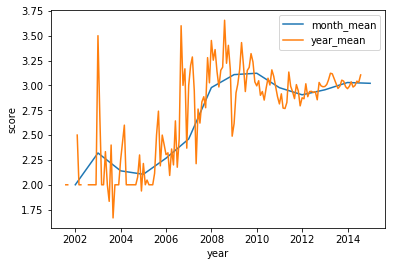

In [147]:
#### I plot the mean rating stars for every year and every month

plt.plot(time_star.resample('A').apply(np.mean),label='month_mean')
plt.plot(time_star.resample('M').apply(np.mean),label='year_mean')
plt.ylabel('score')
plt.xlabel('year')
plt.legend(loc='best')
plt.show()

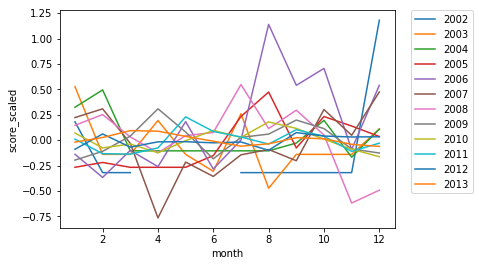

In [148]:
#### I plot the average rating stars of 12 months in each year minus the average rating stars of that year
#### sorry I cannot find any pattern

time_star_rs=time_star.resample('M').apply(np.mean)
for i in range(2002,2014):
    year_mean=time_star.resample('A').apply(np.mean)[str(i)].values[0]
    plt.plot(range(1,13),time_star_rs[str(i)]-year_mean,label=str(i))
plt.ylabel('score_scaled')
plt.xlabel('month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Step 3.5: Neural networks

The baseline models were are random forests. What other algorithms could be used? In a neural network, how many layers and nodes? Any convolutions or recurrences? How do you keep the model from overfitting? What regularization is appropriate? Is the task too hard or too easy for a neural network?

In [149]:
#### I attempt to use NN here to do the classification
#### NN with four hidden layer, around 12 neuros each layer perform better
#### for scaled data, I find minmax or standard perform better
#### for sgns and sppmi data, I find sppmi perform better

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
def neural_evaluate(x_doc_vecs,y):
    x_train, x_test, y_train, y_test = train_test_split(x_doc_vecs,y)
    scores=[]
    for i in range(5,12):
#         print(max(2*i,1))
        nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, max(1,2*i)), random_state=1)
        src=nn.fit(x_train, y_train) 
        pred=nn.predict(x_test)
        scores.append(nn.score(x_test,y_test))
    return scores

In [150]:
# scores_minmax=neural_evaluate(vecs_sgns_minmax,y)
scores_std=neural_evaluate(vecs_sgns_std,y)
# scores_log=neural_evaluate(vecs_sgns_log,y)
# scores_exp=neural_evaluate(vecs_sgns_exp,y)
# scores_bin=neural_evaluate(vecs_sgns_bin,y)
scores_bimean=neural_evaluate(vecs_sgns_bimean,y)

In [151]:
print(scores_std,scores_bimean)

[0.78648, 0.79, 0.7848, 0.78732, 0.78776, 0.78888, 0.78872] [0.7004, 0.606, 0.63064, 0.48108, 0.1982, 0.60504, 0.73092]


In [152]:
# scores_minmax=neural_evaluate(vecs_sppmi_minmax,y)
scores_std=neural_evaluate(vecs_sppmi_std,y)
# scores_log=neural_evaluate(vecs_sppmi_log,y)
# scores_exp=neural_evaluate(vecs_sppmi_exp,y)
# scores_bin=neural_evaluate(vecs_sppmi_bin,y)
scores_bimean=neural_evaluate(vecs_sppmi_bimean,y)

In [153]:
print(scores_std,scores_bimean)

[0.84692, 0.8482, 0.84844, 0.84748, 0.8468, 0.84992, 0.84772] [0.65044, 0.65836, 0.70704, 0.64416, 0.19872, 0.49852, 0.49844]


### Step 3.6: Other enhancements

You may use any other techniques from this class and beyond. Feel free to explore!

In [158]:
#### I attempt to use SVM classification but it does not work well here
#### SVM has very low performance

from sklearn import svm
from sklearn.model_selection import train_test_split

#svm classification
def svm_evaluate(x_doc_vecs,y):
    x_train, x_test, y_train, y_test = train_test_split(x_doc_vecs,y)
    scores=[]
    for i in range(10):
        svm_ = svm.SVC(gamma='scale',max_iter=10*i,C=1.0)
        src=svm_.fit(x_train, y_train) 
        pred=svm_.predict(x_test)
        scores.append(svm_.score(x_test,y_test))
    return scores


In [159]:
scores_minmax=svm_evaluate(vecs_sgns_minmax,y)
scores_std=svm_evaluate(vecs_sgns_std,y)
scores_log=svm_evaluate(vecs_sgns_log,y)
scores_exp=svm_evaluate(vecs_sgns_exp,y)
scores_bin=svm_evaluate(vecs_sgns_bin,y)
scores_bimean=svm_evaluate(vecs_sgns_bimean,y)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=0).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=30).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: C

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
scores_minmax=svm_evaluate(vecs_sppmi_minmax,y)
scores_std=svm_evaluate(vecs_sppmi_std,y)
scores_log=svm_evaluate(vecs_sppmi_log,y)
scores_exp=svm_evaluate(vecs_sppmi_exp,y)
scores_bin=svm_evaluate(vecs_sppmi_bin,y)
scores_bimean=svm_evaluate(vecs_sppmi_bimean,y)

In [ ]:
#### I attempt to use decision tree classification
#### the best score I get is from NN
#### in decision tree vecs_sppmi performs better than vecs_sgns
#### minmax and standard scaled data have better performance here

from sklearn import tree

def tree_evaluate(x_doc_vecs,y):
    x_train, x_test, y_train, y_test = train_test_split(x_doc_vecs,y)
    scores=[]
    for i in range(15):
#         print(max(2*i,1))
        dt = tree.DecisionTreeClassifier(max_depth=max(2*i,1))
        src=dt.fit(x_train, y_train) 
        pred=dt.predict(x_test)
        scores.append(dt.score(x_test,y_test))
    return scores
        

In [ ]:
scores_minmax=tree_evaluate(vecs_sgns_minmax,y)
# scores_std=tree_evaluate(vecs_sgns_std,y)
scores_log=tree_evaluate(vecs_sgns_log,y)
# scores_exp=tree_evaluate(vecs_sgns_exp,y)
scores_bin=tree_evaluate(vecs_sgns_bin,y)
scores_bimean=tree_evaluate(vecs_sgns_bimean,y)

In [ ]:
print(scores_minmax,scores_log,scores_bin,scores_bimean)

In [ ]:
# scores_minmax=tree_evaluate(vecs_sppmi_minmax,y)
scores_std=tree_evaluate(vecs_sppmi_std,y)
# scores_log=tree_evaluate(vecs_sppmi_log,y)
# scores_exp=tree_evaluate(vecs_sppmi_exp,y)
scores_bin=tree_evaluate(vecs_sppmi_bin,y)
scores_bimean=tree_evaluate(vecs_sppmi_bimean,y)

In [ ]:
print(scores_std,scores_bin,scores_bimean)